<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

## Capstone Project: Unsupervised Text Clustering using Natural Language Processing (NLP)


### Introduction

Unsupervised learning is a type of algorithm that learns patterns from untagged data. As part of unsupervised learning, clustering is used to group similar data points without knowing which cluster the data belong to. So in a sense, text clustering is about how similar texts (or sentences) are grouped together. 

In this project, we would look at the stories shared by donors from Give.asia, and using machine learning to find common aspects in donors for the reason/s of giving. Clustering is useful to obtain general insights and information of the donors, and these information can potentially be used to shape future donor's engagement or donor journey maps.  

Founded in 2009. Give.asia is Asia's leading free fundraising platform for fundraisers to raise money for their causes. This social enterprise have helped more than 20,000 campaigns across APAC, raising more than SGD$100 million. 



### Problem Statement


In [1]:
# Imports
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import re


%matplotlib inline

# Do not display future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/shuxiangoh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shuxiangoh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
#Set viewing options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### Part 1: Data Cleaning 

In [4]:
df = pd.read_csv('../dataset/donor_stories.csv')
df.head()

user_id   submitted_at                                            content
0    85942  1548996996000  [{"type":"header","content":"What motivated yo...
1   148748  1548947127000  [{"type":"header","content":"What motivated yo...
2    90783  1548858176000  [{"type":"header","content":"What motivated yo...
3    46769  1547617916000  [{"type":"header","content":"What motivated yo...
4   105858  1549017077000  [{"type":"header","content":"What motivated yo...

In [5]:
df.shape

(328, 3)

In [6]:
#sample of what's in the content
df['content'][1]

'[{"type":"header","content":"What motivated you to make your recent donation?"},{"type":"text","content":"The result of combine effort is incredulous. Every one of us just have to put in a tiny bit. To the individual it may just be a meal\'s worth, but when combine, it may just save a life."},{"type":"header","content":"Why did you choose the cause that you recently supported?"},{"type":"text","content":"It\'s quite heart-wrecking to see the family of the person that needs help, struggling not just with the emotional part, the physical body taking a toil and yet again tormented by the financial burden... imagine the stress that they have to go through."},{"type":"header","content":"Can you share with us something you have learned from your giving journey?"},{"type":"text","content":"Pay it forward."},{"type":"header","content":"What advice will you give to people who are thinking of starting to give back?"},{"type":"text","content":"Think of those who are more unfortunate than you..."

#### Observations

There are 4 repeated questions asked in each of the donor stories, namely:

1. What motivated you to make your recent donation?
2. Why did you choose the cause that you recently supported?
3. Can you share with us something you have learned from your giving journey?
4. What advice will you give to people who are thinking of starting to give back? 


To clean the content of the stories, we can separate the questions into 4 columns and sort the responses into their respective columns. 

In [7]:
#^\|[^\w\|]*(\w+\s+(?=\w+)[^\|]*)

In [8]:
#split df['content'] into different columns 
stories = df.content.str.split(pat = '},', expand = True)
stories.head()

0                                                  1                                                  2                                                  3                                                  4                                                  5                                                  6                                                  7
0  [{"type":"header","content":"What motivated yo...  {"type":"text","content":"The little girl Chlo...  {"type":"header","content":"Why did you choose...  {"type":"text","content":"I am a mother of 2 y...  {"type":"header","content":"Can you share with...  {"type":"text","content":"Every person can pla...  {"type":"header","content":"What advice will y...  {"type":"text","content":"The way to truly exp...
1  [{"type":"header","content":"What motivated yo...  {"type":"text","content":"The result of combin...  {"type":"header","content":"Why did you choose...  {"type":"text","content":"It's quite heart-wre...  {"type":"header","content":"Can you share with...         {"type":"text","content":"Pay it forward."  {"type":"header","content":"What advice will y...  {"type":"text","content":"Think of those who a...
2  [{"type":"header","content":"What motivated yo...  {"type":"text","content":"Children has soft sp...  {"type":"header","content":"Why did you choose...  {"type":"text","content":"Because i have a a c...  {"type":"header","content":"Can you share with...  {"type":"text","content":"To give something to...  {"type":"header","content":"What advice will y...  {"type":"text","content":"Its the best feeling...
3  [{"type":"header","content":"What motivated yo...  {"type":"text","content":"Freely I received, f...  {"type":"header","content":"Why did you choose...  {"type":"text","content":"I have a heart for c...  {"type":"header","content":"Can you share with...  {"type":"text","content":"There are so many wh...  {"type":"header","content":"What advice will y...  {"type":"text","content":"Just give what you c...
4  [{"type":"header","content":"What motivated yo...  {"type":"text","content":"My heart broke when ...  {"type":"header","content":"Why did you choose...  {"type":"text","content":"I'm a mother myself ...  {"type":"header","content":"Can you share with...  {"type":"text","content":"I learned to appreci...  {"type":"header","content":"What advice will y...  {"type":"text","content":"Help the needy. You'...

In [9]:
#check if the split is done correctly for every question column (Column 0, 2, 4, 6)
print(stories[0].nunique())
print(stories[2].nunique())
print(stories[4].nunique())
print(stories[6].nunique())

1
2
2
1


In [10]:
stories[0].unique()

array(['[{"type":"header","content":"What motivated you to make your recent donation?"'],
      dtype=object)

In [11]:
stories[2].unique()
#Column 2 is supposed to be "Why did you choose the cause that you recently supported?"
#need to manually clean the rows that have the responses misplaced

array(['{"type":"header","content":"Why did you choose the cause that you recently supported?"',
       '{"type":"header","content":"Can you share with us something you have learned from your giving journey?"'],
      dtype=object)

In [12]:
stories[4].unique()
#column 4 is supposed to be "Can you share with us something you have learned from your giving journey?"
#need to manually clean the rows that have the responses misplaced

array(['{"type":"header","content":"Can you share with us something you have learned from your giving journey?"',
       '{"type":"header","content":"What advice will you give to people who are thinking of starting to give back?"'],
      dtype=object)

In [13]:
stories[6].unique()

array(['{"type":"header","content":"What advice will you give to people who are thinking of starting to give back?"',
       None], dtype=object)

In [14]:
stories

0                                                  1                                                  2                                                  3                                                  4                                                  5                                                  6                                                  7
0    [{"type":"header","content":"What motivated yo...  {"type":"text","content":"The little girl Chlo...  {"type":"header","content":"Why did you choose...  {"type":"text","content":"I am a mother of 2 y...  {"type":"header","content":"Can you share with...  {"type":"text","content":"Every person can pla...  {"type":"header","content":"What advice will y...  {"type":"text","content":"The way to truly exp...
1    [{"type":"header","content":"What motivated yo...  {"type":"text","content":"The result of combin...  {"type":"header","content":"Why did you choose...  {"type":"text","content":"It's quite heart-wre...  {"type":"header","content":"Can you share with...         {"type":"text","content":"Pay it forward."  {"type":"header","content":"What advice will y...  {"type":"text","content":"Think of those who a...
2    [{"type":"header","content":"What motivated yo...  {"type":"text","content":"Children has soft sp...  {"type":"header","content":"Why did you choose...  {"type":"text","content":"Because i have a a c...  {"type":"header","content":"Can you share with...  {"type":"text","content":"To give something to...  {"type":"header","content":"What advice will y...  {"type":"text","content":"Its the best feeling...
3    [{"type":"header","content":"What motivated yo...  {"type":"text","content":"Freely I received, f...  {"type":"header","content":"Why did you choose...  {"type":"text","content":"I have a heart for c...  {"type":"header","content":"Can you share with...  {"type":"text","content":"There are so many wh...  {"type":"header","content":"What advice will y...  {"type":"text","content":"Just give what you c...
4    [{"type":"header","content":"What motivated yo...  {"type":"text","content":"My heart broke when ...  {"type":"header","content":"Why did you choose...  {"type":"text","content":"I'm a mother myself ...  {"type":"header","content":"Can you share with...  {"type":"text","content":"I learned to appreci...  {"type":"header","content":"What advice will y...  {"type":"text","content":"Help the needy. You'...
5    [{"type":"header","content":"What motivated yo...  {"type":"text","content":"Giving and hope to c...  {"type":"header","content":"Why did you choose...  {"type":"text","content":"To change people's l...  {"type":"header","content":"Can you share with...  {"type":"text","content":"Happiness. Once i go...  {"type":"header","content":"What advice will y...    {"type":"text","content":"Give what you can."}]
6    [{"type":"header","content":"What motivated yo...  {"type":"text","content":"Every time when I he...  {"type":"header","content":"Why did you choose...  {"type":"text","content":"If can save others p...  {"type":"header","content":"Can you share with...  {"type":"text","content":"Good-heartedness oft...  {"type":"header","content":"What advice will y...  {"type":"text","content":"Your kindness would ...
7    [{"type":"header","content":"What motivated yo...  {"type":"text","content":"Hoping to give the r...  {"type":"header","content":"Why did you choose...  {"type":"text","content":"Having kids of my ow...  {"type":"header","content":"Can you share with...  {"type":"text","content":"When you give, no ma...  {"type":"header","content":"What advice will y...  {"type":"text","content":"Never think about th...
8    [{"type":"header","content":"What motivated yo...  {"type":"text","content":"I believe that we we...  {"type":"header","content":"Why did you choose...  {"type":"text","content":"It breaks my heart t...  {"type":"header","content":"Can you share with...  {"type":"text","content":"Sir Winston Churchil...  {"type":"header","content":"What a

In [15]:
contain_values = stories[stories[2].str.contains('Can')]
contain_values

0                                                  1                                                  2                                                  3                                                  4                                                  5     6     7
206  [{"type":"header","content":"What motivated yo...  {"type":"text","content":"No one particular re...  {"type":"header","content":"Can you share with...  {"type":"text","content":"Whatever it is, its ...  {"type":"header","content":"What advice will y...  {"type":"text","content":"I think of myself as...  None  None
215  [{"type":"header","content":"What motivated yo...  {"type":"text","content":"John 3:16 God gave.....  {"type":"header","content":"Can you share with...  {"type":"text","content":"A little will become...  {"type":"header","content":"What advice will y...  {"type":"text","content":"Any amount helps. Do...  None  None
225  [{"type":"header","content":"What motivated yo...  {"type":"text","content":"When I read Anik's s...  {"type":"header","content":"Can you share with...  {"type":"text","content":"Giving to others is ...  {"type":"header","content":"What advice will y...  {"type":"text","content":"Every bit you give w...  None  None

In [16]:
df1 = contain_values[[0,1,6,7,2,3,4,5]]

In [17]:
df1

0                                                  1     6     7                                                  2                                                  3                                                  4                                                  5
206  [{"type":"header","content":"What motivated yo...  {"type":"text","content":"No one particular re...  None  None  {"type":"header","content":"Can you share with...  {"type":"text","content":"Whatever it is, its ...  {"type":"header","content":"What advice will y...  {"type":"text","content":"I think of myself as...
215  [{"type":"header","content":"What motivated yo...  {"type":"text","content":"John 3:16 God gave.....  None  None  {"type":"header","content":"Can you share with...  {"type":"text","content":"A little will become...  {"type":"header","content":"What advice will y...  {"type":"text","content":"Any amount helps. Do...
225  [{"type":"header","content":"What motivated yo...  {"type":"text","content":"When I read Anik's s...  None  None  {"type":"header","content":"Can you share with...  {"type":"text","content":"Giving to others is ...  {"type":"header","content":"What advice will y...  {"type":"text","content":"Every bit you give w...

In [18]:
#rename columns
df2 = df1.rename(columns = {6: 2, 7: 3, 2: 4, 3: 5, 4:6, 5:7})
df2

0                                                  1     2     3                                                  4                                                  5                                                  6                                                  7
206  [{"type":"header","content":"What motivated yo...  {"type":"text","content":"No one particular re...  None  None  {"type":"header","content":"Can you share with...  {"type":"text","content":"Whatever it is, its ...  {"type":"header","content":"What advice will y...  {"type":"text","content":"I think of myself as...
215  [{"type":"header","content":"What motivated yo...  {"type":"text","content":"John 3:16 God gave.....  None  None  {"type":"header","content":"Can you share with...  {"type":"text","content":"A little will become...  {"type":"header","content":"What advice will y...  {"type":"text","content":"Any amount helps. Do...
225  [{"type":"header","content":"What motivated yo...  {"type":"text","content":"When I read Anik's s...  None  None  {"type":"header","content":"Can you share with...  {"type":"text","content":"Giving to others is ...  {"type":"header","content":"What advice will y...  {"type":"text","content":"Every bit you give w...

In [19]:
stories = stories.drop(labels = [206,215,225], axis = 0)

In [20]:
stories.shape

(325, 8)

In [21]:
#to concatenate the 2 dataframes 
frames = [stories, df2]
result = pd.concat(frames)

In [22]:
result

0                                                  1                                                  2                                                  3                                                  4                                                  5                                                  6                                                  7
0    [{"type":"header","content":"What motivated yo...  {"type":"text","content":"The little girl Chlo...  {"type":"header","content":"Why did you choose...  {"type":"text","content":"I am a mother of 2 y...  {"type":"header","content":"Can you share with...  {"type":"text","content":"Every person can pla...  {"type":"header","content":"What advice will y...  {"type":"text","content":"The way to truly exp...
1    [{"type":"header","content":"What motivated yo...  {"type":"text","content":"The result of combin...  {"type":"header","content":"Why did you choose...  {"type":"text","content":"It's quite heart-wre...  {"type":"header","content":"Can you share with...         {"type":"text","content":"Pay it forward."  {"type":"header","content":"What advice will y...  {"type":"text","content":"Think of those who a...
2    [{"type":"header","content":"What motivated yo...  {"type":"text","content":"Children has soft sp...  {"type":"header","content":"Why did you choose...  {"type":"text","content":"Because i have a a c...  {"type":"header","content":"Can you share with...  {"type":"text","content":"To give something to...  {"type":"header","content":"What advice will y...  {"type":"text","content":"Its the best feeling...
3    [{"type":"header","content":"What motivated yo...  {"type":"text","content":"Freely I received, f...  {"type":"header","content":"Why did you choose...  {"type":"text","content":"I have a heart for c...  {"type":"header","content":"Can you share with...  {"type":"text","content":"There are so many wh...  {"type":"header","content":"What advice will y...  {"type":"text","content":"Just give what you c...
4    [{"type":"header","content":"What motivated yo...  {"type":"text","content":"My heart broke when ...  {"type":"header","content":"Why did you choose...  {"type":"text","content":"I'm a mother myself ...  {"type":"header","content":"Can you share with...  {"type":"text","content":"I learned to appreci...  {"type":"header","content":"What advice will y...  {"type":"text","content":"Help the needy. You'...
5    [{"type":"header","content":"What motivated yo...  {"type":"text","content":"Giving and hope to c...  {"type":"header","content":"Why did you choose...  {"type":"text","content":"To change people's l...  {"type":"header","content":"Can you share with...  {"type":"text","content":"Happiness. Once i go...  {"type":"header","content":"What advice will y...    {"type":"text","content":"Give what you can."}]
6    [{"type":"header","content":"What motivated yo...  {"type":"text","content":"Every time when I he...  {"type":"header","content":"Why did you choose...  {"type":"text","content":"If can save others p...  {"type":"header","content":"Can you share with...  {"type":"text","content":"Good-heartedness oft...  {"type":"header","content":"What advice will y...  {"type":"text","content":"Your kindness would ...
7    [{"type":"header","content":"What motivated yo...  {"type":"text","content":"Hoping to give the r...  {"type":"header","content":"Why did you choose...  {"type":"text","content":"Having kids of my ow...  {"type":"header","content":"Can you share with...  {"type":"text","content":"When you give, no ma...  {"type":"header","content":"What advice will y...  {"type":"text","content":"Never think about th...
8    [{"type":"header","content":"What motivated yo...  {"type":"text","content":"I believe that we we...  {"type":"header","content":"Why did you choose...  {"type":"text","content":"It breaks my heart t...  {"type":"header","content":"Can you share with...  {"type":"text","content":"Sir Winston Churchil...  {"type":"header","content":"What a

In [23]:
#sort the index 
result_cleaned = result.sort_index()
result_cleaned

0                                                  1                                                  2                                                  3                                                  4                                                  5                                                  6                                                  7
0    [{"type":"header","content":"What motivated yo...  {"type":"text","content":"The little girl Chlo...  {"type":"header","content":"Why did you choose...  {"type":"text","content":"I am a mother of 2 y...  {"type":"header","content":"Can you share with...  {"type":"text","content":"Every person can pla...  {"type":"header","content":"What advice will y...  {"type":"text","content":"The way to truly exp...
1    [{"type":"header","content":"What motivated yo...  {"type":"text","content":"The result of combin...  {"type":"header","content":"Why did you choose...  {"type":"text","content":"It's quite heart-wre...  {"type":"header","content":"Can you share with...         {"type":"text","content":"Pay it forward."  {"type":"header","content":"What advice will y...  {"type":"text","content":"Think of those who a...
2    [{"type":"header","content":"What motivated yo...  {"type":"text","content":"Children has soft sp...  {"type":"header","content":"Why did you choose...  {"type":"text","content":"Because i have a a c...  {"type":"header","content":"Can you share with...  {"type":"text","content":"To give something to...  {"type":"header","content":"What advice will y...  {"type":"text","content":"Its the best feeling...
3    [{"type":"header","content":"What motivated yo...  {"type":"text","content":"Freely I received, f...  {"type":"header","content":"Why did you choose...  {"type":"text","content":"I have a heart for c...  {"type":"header","content":"Can you share with...  {"type":"text","content":"There are so many wh...  {"type":"header","content":"What advice will y...  {"type":"text","content":"Just give what you c...
4    [{"type":"header","content":"What motivated yo...  {"type":"text","content":"My heart broke when ...  {"type":"header","content":"Why did you choose...  {"type":"text","content":"I'm a mother myself ...  {"type":"header","content":"Can you share with...  {"type":"text","content":"I learned to appreci...  {"type":"header","content":"What advice will y...  {"type":"text","content":"Help the needy. You'...
5    [{"type":"header","content":"What motivated yo...  {"type":"text","content":"Giving and hope to c...  {"type":"header","content":"Why did you choose...  {"type":"text","content":"To change people's l...  {"type":"header","content":"Can you share with...  {"type":"text","content":"Happiness. Once i go...  {"type":"header","content":"What advice will y...    {"type":"text","content":"Give what you can."}]
6    [{"type":"header","content":"What motivated yo...  {"type":"text","content":"Every time when I he...  {"type":"header","content":"Why did you choose...  {"type":"text","content":"If can save others p...  {"type":"header","content":"Can you share with...  {"type":"text","content":"Good-heartedness oft...  {"type":"header","content":"What advice will y...  {"type":"text","content":"Your kindness would ...
7    [{"type":"header","content":"What motivated yo...  {"type":"text","content":"Hoping to give the r...  {"type":"header","content":"Why did you choose...  {"type":"text","content":"Having kids of my ow...  {"type":"header","content":"Can you share with...  {"type":"text","content":"When you give, no ma...  {"type":"header","content":"What advice will y...  {"type":"text","content":"Never think about th...
8    [{"type":"header","content":"What motivated yo...  {"type":"text","content":"I believe that we we...  {"type":"header","content":"Why did you choose...  {"type":"text","content":"It breaks my heart t...  {"type":"header","content":"Can you share with...  {"type":"text","content":"Sir Winston Churchil...  {"type":"header","content":"What a

In [24]:
#replace colume name with question
df = result_cleaned.rename(columns = {1:'What motivated you to make your recent donation?', 
                                      3:'Why did you choose the cause that you recently supported?',
                                      5:'Can you share with us something you have learned from your giving journey?',
                                      7:'What advice will you give to people who are thinking of starting to give back?'
                                     })

In [25]:
df

0   What motivated you to make your recent donation?                                                  2 Why did you choose the cause that you recently supported?                                                  4 Can you share with us something you have learned from your giving journey?                                                  6 What advice will you give to people who are thinking of starting to give back?
0    [{"type":"header","content":"What motivated yo...  {"type":"text","content":"The little girl Chlo...  {"type":"header","content":"Why did you choose...  {"type":"text","content":"I am a mother of 2 y...         {"type":"header","content":"Can you share with...  {"type":"text","content":"Every person can pla...                          {"type":"header","content":"What advice will y...  {"type":"text","content":"The way to truly exp...                            
1    [{"type":"header","content":"What motivated yo...  {"type":"text","content":"The result of combin...  {"type":"header","content":"Why did you choose...  {"type":"text","content":"It's quite heart-wre...         {"type":"header","content":"Can you share with...         {"type":"text","content":"Pay it forward."                          {"type":"header","content":"What advice will y...  {"type":"text","content":"Think of those who a...                            
2    [{"type":"header","content":"What motivated yo...  {"type":"text","content":"Children has soft sp...  {"type":"header","content":"Why did you choose...  {"type":"text","content":"Because i have a a c...         {"type":"header","content":"Can you share with...  {"type":"text","content":"To give something to...                          {"type":"header","content":"What advice will y...  {"type":"text","content":"Its the best feeling...                            
3    [{"type":"header","content":"What motivated yo...  {"type":"text","content":"Freely I received, f...  {"type":"header","content":"Why did you choose...  {"type":"text","content":"I have a heart for c...         {"type":"header","content":"Can you share with...  {"type":"text","content":"There are so many wh...                          {"type":"header","content":"What advice will y...  {"type":"text","content":"Just give what you c...                            
4    [{"type":"header","content":"What motivated yo...  {"type":"text","content":"My heart broke when ...  {"type":"header","content":"Why did you choose...  {"type":"text","content":"I'm a mother myself ...         {"type":"header","content":"Can you share with...  {"type":"text","content":"I learned to appreci...                          {"type":"header","content":"What advice will y...  {"type":"text","content":"Help the needy. You'...                            
5    [{"type":"header","content":"What motivated yo...  {"type":"text","content":"Giving and hope to c...  {"type":"header","content":"Why did you choose...  {"type":"text","content":"To change people's l...         {"type":"header","content":"Can you share with...  {"type":"text","content":"Happiness. Once i go...                          {"type":"header","content":"What advice will y...    {"type":"text","content":"Give what you can."}]                            
6    [{"type":"header","content":"What motivated yo...  {"type":"text","content":"Every time when I he...  {"type":"header","content":"Why did you choose...  {"type":"text","content":"If can save others p...         {"type":"header","content":"Can you share with...  {"type":"text","content":"Good-heartedness oft...                          {"type":"header","content":"What advice will y...  {"type":"text","content":"Your kindness would ...                            
7    [{"type":"header","content":"What motivated yo...  {"type":"text","content":"Hoping to give the r...  {"type":"header","content":"Why did you choose...  {"type":"text","content":"Having kids of my ow...         {"type":"header","content":"Can you share with...  {"type":"text","co

In [26]:
#remove question columns (0, 2, 4, 6)
df.drop(columns = [0,2,4,6], inplace = True)

In [27]:
df

What motivated you to make your recent donation? Why did you choose the cause that you recently supported? Can you share with us something you have learned from your giving journey? What advice will you give to people who are thinking of starting to give back?
0    {"type":"text","content":"The little girl Chlo...  {"type":"text","content":"I am a mother of 2 y...         {"type":"text","content":"Every person can pla...                          {"type":"text","content":"The way to truly exp...                            
1    {"type":"text","content":"The result of combin...  {"type":"text","content":"It's quite heart-wre...                {"type":"text","content":"Pay it forward."                          {"type":"text","content":"Think of those who a...                            
2    {"type":"text","content":"Children has soft sp...  {"type":"text","content":"Because i have a a c...         {"type":"text","content":"To give something to...                          {"type":"text","content":"Its the best feeling...                            
3    {"type":"text","content":"Freely I received, f...  {"type":"text","content":"I have a heart for c...         {"type":"text","content":"There are so many wh...                          {"type":"text","content":"Just give what you c...                            
4    {"type":"text","content":"My heart broke when ...  {"type":"text","content":"I'm a mother myself ...         {"type":"text","content":"I learned to appreci...                          {"type":"text","content":"Help the needy. You'...                            
5    {"type":"text","content":"Giving and hope to c...  {"type":"text","content":"To change people's l...         {"type":"text","content":"Happiness. Once i go...                            {"type":"text","content":"Give what you can."}]                            
6    {"type":"text","content":"Every time when I he...  {"type":"text","content":"If can save others p...         {"type":"text","content":"Good-heartedness oft...                          {"type":"text","content":"Your kindness would ...                            
7    {"type":"text","content":"Hoping to give the r...  {"type":"text","content":"Having kids of my ow...         {"type":"text","content":"When you give, no ma...                          {"type":"text","content":"Never think about th...                            
8    {"type":"text","content":"I believe that we we...  {"type":"text","content":"It breaks my heart t...         {"type":"text","content":"Sir Winston Churchil...                          {"type":"text","content":"I want to share what...                            
9    {"type":"text","content":"It is a blessing to ...  {"type":"text","content":"Having to taken care...         {"type":"text","content":"To give whatever we ...                             {"type":"text","content":"To give is a joy "}]                            
10   {"type":"text","content":"It pains me every ti...  {"type":"text","content":"I donate whenever I ...         {"type":"text","content":"I learnt that being ...                          {"type":"text","content":"Just do your best to...                            
11   {"type":"text","content":"Giving is a blessing...            {"type":"text","content":"Their story."         {"type":"text","content":"Generosity is not ab...                          {"type":"text","content":"Don’t judge, don’t h...                            
12   {"type":"text","content":"The plight faced by ...  {"type":"text","content":"I think some childre...         {"type":"text","content":"I once read an artic...                          {"type":"text","content":"A little amount may ...                            
13   {"type":"text","content":"The joy in giving is...  {"type":"text","content":"Children and elderly...         {"type":"text","content":"Gratitude  - that i ...                          {"type":"text","content":"Try it, and its addi...                            
1

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 328 entries, 0 to 327
Data columns (total 4 columns):
 #   Column                                                                          Non-Null Count  Dtype 
---  ------                                                                          --------------  ----- 
 0   What motivated you to make your recent donation?                                328 non-null    object
 1   Why did you choose the cause that you recently supported?                       325 non-null    object
 2   Can you share with us something you have learned from your giving journey?      328 non-null    object
 3   What advice will you give to people who are thinking of starting to give back?  327 non-null    object
dtypes: object(4)
memory usage: 12.8+ KB


In [29]:
#identify chinese rows
df.loc[[311, 321]]

What motivated you to make your recent donation? Why did you choose the cause that you recently supported? Can you share with us something you have learned from your giving journey? What advice will you give to people who are thinking of starting to give back?
311  {"type":"text","content":"我是一名执业的中医师，我的专业让我还能继...            {"type":"text","content":"哪里有需要我能力所及就做"         {"type":"text","content":"社会必需要有慈悲、仁爱，大家才会有希望，...                          {"type":"text","content":"不应善小而不为；无论捐款多少数额都是在做...                            
321  {"type":"text","content":"没有什么促进我捐款，只是这是我从小到大的...              {"type":"text","content":"想帮助有需要帮助的人"                         {"type":"text","content":"只想积极参与"                                           {"type":"text","content":"不知道"}]

In [30]:
#replace chinese text with translated text from google for index 311
df.loc[311, 'What motivated you to make your recent donation?'] = 'I am a practicing traditional Chinese medicine practitioner. My major allows me to continue to serve the public. I have seen all the staff of the national government departments, and so many people who are working hard in different positions to do this for the nationals and foreign workers. National leaders and social volunteers are all "fighting" for this epidemic. Seeing that the society is full of compassion, benevolence, and concerted efforts for the public, what I donate is only a small thought. I hope that the poor people in society will not suffer from hunger.'
df.loc[311, 'Why did you choose the cause that you recently supported?'] = 'Wherever there is a need, I will do it'
df.loc[311, 'Can you share with us something you have learned from your giving journey?'] = 'The society must have compassion and benevolence, so that everyone can have hope, and everyone can live together.'
df.loc[311, 'What advice will you give to people who are thinking of starting to give back?'] = 'Regardless the amount you donate, you are doing good deeds. Do not underestimate the small amount donated. Kindness will bring us a grateful heart, happiness and satisfaction.'

In [31]:
##replace chinese text with translated text from google for index 321
df.loc[321, 'What motivated you to make your recent donation?'] = 'Nothing motivates me to donate, it\'s just my childhood dream to do my best to help all the poor. I am a Malaysian citizen and now working in Singapore, and my salary can be said to be the lowest salary in Singapore (1500) and there is almost no overtime pay. I just want to help others or donate, but I don’t want anyone to know my name, including the beneficiary of the donation. I also want to be a volunteer. Unfortunately, I don’t know where I can do volunteer work in Singapore. If not for the clash in working hours, I would volunteer most of the time.  It\'s a pity that I didn\'t know that there is this platform to help others until recently. it\'s a pity that I\'m not a rich person, it is a shame that i can only donate five to ten dollars each time.'
df.loc[321, 'Why did you choose the cause that you recently supported?'] = 'want to help those in need'
df.loc[321, 'Can you share with us something you have learned from your giving journey?'] = 'just want to actively participate'
df.loc[321, 'What advice will you give to people who are thinking of starting to give back?'] = 'i don\'t know'

In [32]:
#replace null values with 'empty'
df = df.fillna('empty')

In [33]:
#Define a function to clean text data 
#remove whitespace, keep only alphabet characters and make lowercase

col_list = ['What motivated you to make your recent donation?', 
            'Why did you choose the cause that you recently supported?',
            'Can you share with us something you have learned from your giving journey?',
            'What advice will you give to people who are thinking of starting to give back?']


def tokenize_data(data, col_list):
    tokenizer = RegexpTokenizer(r'[a-zA-ZИ]+')
    
    for col in col_list:
        tokenized_items = [tokenizer.tokenize(item.lower()) for item in data[col]]
        data[f'tokenized_{col}'] = tokenized_items
    return data

In [34]:
df = tokenize_data(df, col_list)
df.head()

What motivated you to make your recent donation? Why did you choose the cause that you recently supported? Can you share with us something you have learned from your giving journey? What advice will you give to people who are thinking of starting to give back? tokenized_What motivated you to make your recent donation? tokenized_Why did you choose the cause that you recently supported? tokenized_Can you share with us something you have learned from your giving journey? tokenized_What advice will you give to people who are thinking of starting to give back?
0  {"type":"text","content":"The little girl Chlo...  {"type":"text","content":"I am a mother of 2 y...         {"type":"text","content":"Every person can pla...                          {"type":"text","content":"The way to truly exp...                              [type, text, content, the, little, girl, chloe...          [type, text, content, i, am, a, mother, of, yo...                   [type, text, content, every, person, can, play...                                    [type, text, content, the, way, to, truly, exp...                                      
1  {"type":"text","content":"The result of combin...  {"type":"text","content":"It's quite heart-wre...                {"type":"text","content":"Pay it forward."                          {"type":"text","content":"Think of those who a...                              [type, text, content, the, result, of, combine...          [type, text, content, it, s, quite, heart, wre...                             [type, text, content, pay, it, forward]                                    [type, text, content, think, of, those, who, a...                                      
2  {"type":"text","content":"Children has soft sp...  {"type":"text","content":"Because i have a a c...         {"type":"text","content":"To give something to...                          {"type":"text","content":"Its the best feeling...                              [type, text, content, children, has, soft, spo...          [type, text, content, because, i, have, a, a, ...                   [type, text, content, to, give, something, to,...                                    [type, text, content, its, the, best, feeling,...                                      
3  {"type":"text","content":"Freely I received, f...  {"type":"text","content":"I have a heart for c...         {"type":"text","content":"There are so many wh...                          {"type":"text","content":"Just give what you c...                              [type, text, content, freely, i, received, fre...          [type, text, content, i, have, a, heart, for, ...                   [type, text, content, there, are, so, many, wh...                                    [type, text, content, just, give, what, you, c...                                      
4  {"type":"text","content":"My heart broke when ...  {"type":"text","content":"I'm a mother myself ...         {"type":"text","content":"I learned to appreci...                          {"type":"text","content":"Help the needy. You'...                              [type, text, content, my, heart, broke, when, ...          [type, text, content, i, m, a, mother, myself,...                   [type, text, content, i, learned, to, apprecia...                                    [type, text, content, help, the, needy, you, l...

### Additional Cleaning

Remove strings with low importance to interpretation, for example strings marking websites or other formatting. 

In [35]:
#Remove all strings marking websites or other formatting
add_clean = ['type', 'text', 'content']
df['tokenized_What motivated you to make your recent donation?'] = df['tokenized_What motivated you to make your recent donation?'].apply(lambda row: [word for word in row if word not in add_clean])

In [36]:
df['tokenized_Why did you choose the cause that you recently supported?'] = df['tokenized_Why did you choose the cause that you recently supported?'].apply(lambda row: [word for word in row if word not in add_clean])


In [37]:
df['tokenized_Can you share with us something you have learned from your giving journey?'] = df['tokenized_Can you share with us something you have learned from your giving journey?'].apply(lambda row: [word for word in row if word not in add_clean])


In [38]:
df['tokenized_What advice will you give to people who are thinking of starting to give back?'] = df['tokenized_What advice will you give to people who are thinking of starting to give back?'].apply(lambda row: [word for word in row if word not in add_clean])


In [39]:
df

What motivated you to make your recent donation? Why did you choose the cause that you recently supported? Can you share with us something you have learned from your giving journey? What advice will you give to people who are thinking of starting to give back? tokenized_What motivated you to make your recent donation? tokenized_Why did you choose the cause that you recently supported? tokenized_Can you share with us something you have learned from your giving journey? tokenized_What advice will you give to people who are thinking of starting to give back?
0    {"type":"text","content":"The little girl Chlo...  {"type":"text","content":"I am a mother of 2 y...         {"type":"text","content":"Every person can pla...                          {"type":"text","content":"The way to truly exp...                              [the, little, girl, chloe, looked, so, brave, ...          [i, am, a, mother, of, young, children, it, br...                   [every, person, can, play, a, part, it, is, a,...                                    [the, way, to, truly, experience, joy, is, to,...                                      
1    {"type":"text","content":"The result of combin...  {"type":"text","content":"It's quite heart-wre...                {"type":"text","content":"Pay it forward."                          {"type":"text","content":"Think of those who a...                              [the, result, of, combine, effort, is, incredu...          [it, s, quite, heart, wrecking, to, see, the, ...                                                  [pay, it, forward]                                    [think, of, those, who, are, more, unfortunate...                                      
2    {"type":"text","content":"Children has soft sp...  {"type":"text","content":"Because i have a a c...         {"type":"text","content":"To give something to...                          {"type":"text","content":"Its the best feeling...                              [children, has, soft, spot, in, my, heart, as,...          [because, i, have, a, a, close, friend, who, l...                   [to, give, something, to, sick, children, is, ...                                    [its, the, best, feeling, ever, its, better, t...                                      
3    {"type":"text","content":"Freely I received, f...  {"type":"text","content":"I have a heart for c...         {"type":"text","content":"There are so many wh...                          {"type":"text","content":"Just give what you c...                                  [freely, i, received, freely, i, shall, give]              [i, have, a, heart, for, childrens, i, guess]                   [there, are, so, many, who, needs, help, and, ...                                    [just, give, what, you, can, don, t, think, do...                                      
4    {"type":"text","content":"My heart broke when ...  {"type":"text","content":"I'm a mother myself ...         {"type":"text","content":"I learned to appreci...                          {"type":"text","content":"Help the needy. You'...                              [my, heart, broke, when, i, learned, about, th...          [i, m, a, mother, myself, and, seeing, a, chil...                   [i, learned, to, appreciate, life, more, and, ...                                    [help, the, needy, you, ll, be, more, happier,...                                      
5    {"type":"text","content":"Giving and hope to c...  {"type":"text","content":"To change people's l...         {"type":"text","content":"Happiness. Once i go...                            {"type":"text","content":"Give what you can."}]                              [giving, and, hope, to, change, people, life, ...                              [to, change, people, s, life]                   [happiness, once, i, got, a, email, from, a, d...                                                               [give, what, you, can]                                      
6    {"type":"text","content":

## Exploratory Data Analysis on Posts

#### Post Length

In [40]:
# Calculate length of text
df['q1_text_length'] = df['What motivated you to make your recent donation?'].str.len()
df['q2_text_length'] = df['Why did you choose the cause that you recently supported?'].str.len()
df['q3_text_length'] = df['Can you share with us something you have learned from your giving journey?'].str.len()
df['q4_text_length'] = df['What advice will you give to people who are thinking of starting to give back?'].str.len()

In [41]:
df

What motivated you to make your recent donation? Why did you choose the cause that you recently supported? Can you share with us something you have learned from your giving journey? What advice will you give to people who are thinking of starting to give back? tokenized_What motivated you to make your recent donation? tokenized_Why did you choose the cause that you recently supported? tokenized_Can you share with us something you have learned from your giving journey? tokenized_What advice will you give to people who are thinking of starting to give back?  q1_text_length  q2_text_length  q3_text_length  q4_text_length
0    {"type":"text","content":"The little girl Chlo...  {"type":"text","content":"I am a mother of 2 y...         {"type":"text","content":"Every person can pla...                          {"type":"text","content":"The way to truly exp...                              [the, little, girl, chloe, looked, so, brave, ...          [i, am, a, mother, of, young, children, it, br...                   [every, person, can, play, a, part, it, is, a,...                                    [the, way, to, truly, experience, joy, is, to,...                                                   149             115             146             239
1    {"type":"text","content":"The result of combin...  {"type":"text","content":"It's quite heart-wre...                {"type":"text","content":"Pay it forward."                          {"type":"text","content":"Think of those who a...                              [the, result, of, combine, effort, is, incredu...          [it, s, quite, heart, wrecking, to, see, the, ...                                                  [pay, it, forward]                                    [think, of, those, who, are, more, unfortunate...                                                   211             278              42              80
2    {"type":"text","content":"Children has soft sp...  {"type":"text","content":"Because i have a a c...         {"type":"text","content":"To give something to...                          {"type":"text","content":"Its the best feeling...                              [children, has, soft, spot, in, my, heart, as,...          [because, i, have, a, a, close, friend, who, l...                   [to, give, something, to, sick, children, is, ...                                    [its, the, best, feeling, ever, its, better, t...                                                    88             116             231             119
3    {"type":"text","content":"Freely I received, f...  {"type":"text","content":"I have a heart for c...         {"type":"text","content":"There are so many wh...                          {"type":"text","content":"Just give what you c...                                  [freely, i, received, freely, i, shall, give]              [i, have, a, heart, for, childrens, i, guess]                   [there, are, so, many, who, needs, help, and, ...                                    [just, give, what, you, can, don, t, think, do...                                                    66              64              93              78
4    {"type":"text","content":"My heart broke when ...  {"type":"text","content":"I'm a mother myself ...         {"type":"text","content":"I learned to appreci...                          {"type":"text","content":"Help the needy. You'...                              [my, heart, broke, when, i, learned, about, th...          [i, m, a, mother, myself, and, seeing, a, chil...                   [i, learned, to, appreciate, life, more, and, ...                                    [help, the, needy, you, ll, be, more, happier,...                                                   141             106              89              81
5    {"type":"text","content":"Giving and hope to c...  {"type":"text","content":"To change people's l...         {"type":"text","content":"Happiness. Once i go...                            {"type":"text","content

In [42]:
# Calculate word count
df['q1_text_wordcount'] = df['What motivated you to make your recent donation?'].str.count(' ') + 1
df['q2_text_wordcount'] = df['Why did you choose the cause that you recently supported?'].str.count(' ') + 1
df['q3_text_wordcount'] = df['Can you share with us something you have learned from your giving journey?'].str.count(' ') + 1
df['q4_text_wordcount'] = df['What advice will you give to people who are thinking of starting to give back?'].str.count(' ') + 1

In [43]:
df

What motivated you to make your recent donation? Why did you choose the cause that you recently supported? Can you share with us something you have learned from your giving journey? What advice will you give to people who are thinking of starting to give back? tokenized_What motivated you to make your recent donation? tokenized_Why did you choose the cause that you recently supported? tokenized_Can you share with us something you have learned from your giving journey? tokenized_What advice will you give to people who are thinking of starting to give back?  q1_text_length  q2_text_length  q3_text_length  q4_text_length  q1_text_wordcount  q2_text_wordcount  q3_text_wordcount  q4_text_wordcount
0    {"type":"text","content":"The little girl Chlo...  {"type":"text","content":"I am a mother of 2 y...         {"type":"text","content":"Every person can pla...                          {"type":"text","content":"The way to truly exp...                              [the, little, girl, chloe, looked, so, brave, ...          [i, am, a, mother, of, young, children, it, br...                   [every, person, can, play, a, part, it, is, a,...                                    [the, way, to, truly, experience, joy, is, to,...                                                   149             115             146             239                 23                 19                 24                 41
1    {"type":"text","content":"The result of combin...  {"type":"text","content":"It's quite heart-wre...                {"type":"text","content":"Pay it forward."                          {"type":"text","content":"Think of those who a...                              [the, result, of, combine, effort, is, incredu...          [it, s, quite, heart, wrecking, to, see, the, ...                                                  [pay, it, forward]                                    [think, of, those, who, are, more, unfortunate...                                                   211             278              42              80                 38                 43                  3                  9
2    {"type":"text","content":"Children has soft sp...  {"type":"text","content":"Because i have a a c...         {"type":"text","content":"To give something to...                          {"type":"text","content":"Its the best feeling...                              [children, has, soft, spot, in, my, heart, as,...          [because, i, have, a, a, close, friend, who, l...                   [to, give, something, to, sick, children, is, ...                                    [its, the, best, feeling, ever, its, better, t...                                                    88             116             231             119                 15                 20                 40                 17
3    {"type":"text","content":"Freely I received, f...  {"type":"text","content":"I have a heart for c...         {"type":"text","content":"There are so many wh...                          {"type":"text","content":"Just give what you c...                                  [freely, i, received, freely, i, shall, give]              [i, have, a, heart, for, childrens, i, guess]                   [there, are, so, many, who, needs, help, and, ...                                    [just, give, what, you, can, don, t, think, do...                                                    66              64              93              78                  7                  8                 16                  9
4    {"type":"text","content":"My heart broke when ...  {"type":"text","content":"I'm a mother myself ...         {"type":"text","content":"I learned to appreci...                          {"type":"text","content":"Help the needy. You'...                              [my, heart, broke, when, i, learned, about, th...          [i, m, a, mother, myself, and, seeing, a, chil...                   [i, learned, to, appreciate, life, more, and, ...                      

In [44]:
df_text_length = pd.DataFrame(df, columns =['q1_text_length', 'q2_text_length',
                                           'q3_text_length', 'q4_text_length'])
df_text_length.head()

q1_text_length  q2_text_length  q3_text_length  q4_text_length
0             149             115             146             239
1             211             278              42              80
2              88             116             231             119
3              66              64              93              78
4             141             106              89              81

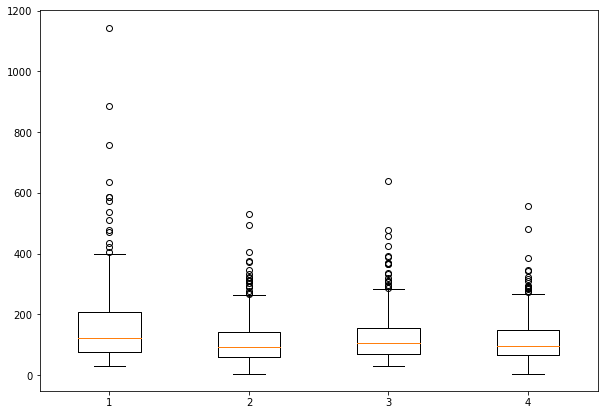

In [45]:
fig = plt.figure(figsize =(10, 7))
 
# Creating boxplot for text_length
plt.boxplot(df_text_length)
 
# show plot
plt.show()

In [46]:
#creating dataframe for text wordcount
df_text_wordcount = pd.DataFrame(df, columns =['q1_text_wordcount', 'q2_text_wordcount',
                                           'q3_text_wordcount', 'q4_text_wordcount'])
df_text_wordcount.head()

q1_text_wordcount  q2_text_wordcount  q3_text_wordcount  q4_text_wordcount
0                 23                 19                 24                 41
1                 38                 43                  3                  9
2                 15                 20                 40                 17
3                  7                  8                 16                  9
4                 22                 14                 13                 11

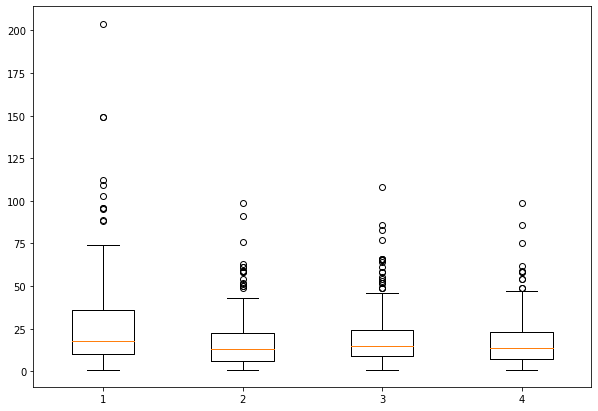

In [47]:
fig = plt.figure(figsize =(10, 7))
 
# Creating boxplot for text_wordcount
plt.boxplot(df_text_wordcount)
 
# show plot
plt.show()

In [56]:
col_list = ['What motivated you to make your recent donation?', 
            'Why did you choose the cause that you recently supported?',
            'Can you share with us something you have learned from your giving journey?',
            'What advice will you give to people who are thinking of starting to give back?']
df_cleaned = df.drop(columns = col_list, axis = 1, inplace = True)

### Pre-processing (part 2)

Stop words are words that have little to no significance or meaning. They are common words that only add to the grammatical structure and flow of the sentence, so it is still relatively easy to identify the contents of sentences without stop words. 

- Stop word removal 

In [57]:
#Remove general stopwords in english language

add_stop = ['empty']
stoplist = stopwords.words('english') + add_stop

df['cleaned_tokens_q1'] = df['tokenized_What motivated you to make your recent donation?'].apply(lambda row: [word for word in row if word not in stoplist])
df['cleaned_tokens_q2'] = df['tokenized_Why did you choose the cause that you recently supported?'].apply(lambda row: [word for word in row if word not in stoplist])
df['cleaned_tokens_q3'] = df['tokenized_Can you share with us something you have learned from your giving journey?'].apply(lambda row: [word for word in row if word not in stoplist])
df['cleaned_tokens_q4'] = df['tokenized_What advice will you give to people who are thinking of starting to give back?'].apply(lambda row: [word for word in row if word not in stoplist])

In [58]:
df.head()

tokenized_What motivated you to make your recent donation? tokenized_Why did you choose the cause that you recently supported? tokenized_Can you share with us something you have learned from your giving journey? tokenized_What advice will you give to people who are thinking of starting to give back?  q1_text_length  q2_text_length  q3_text_length  q4_text_length  q1_text_wordcount  q2_text_wordcount  q3_text_wordcount  q4_text_wordcount                                  cleaned_tokens_q1                                  cleaned_tokens_q2                                  cleaned_tokens_q3                                  cleaned_tokens_q4
0  [the, little, girl, chloe, looked, so, brave, ...          [i, am, a, mother, of, young, children, it, br...                   [every, person, can, play, a, part, it, is, a,...                                    [the, way, to, truly, experience, joy, is, to,...                                                   149             115             146             239                 23                 19                 24                 41  [little, girl, chloe, looked, brave, vibrant, ...  [mother, young, children, breaks, heart, every...  [every, person, play, part, distinct, privileg...  [way, truly, experience, joy, give, something,...
1  [the, result, of, combine, effort, is, incredu...          [it, s, quite, heart, wrecking, to, see, the, ...                                                  [pay, it, forward]                                    [think, of, those, who, are, more, unfortunate...                                                   211             278              42              80                 38                 43                  3                  9  [result, combine, effort, incredulous, every, ...  [quite, heart, wrecking, see, family, person, ...                                     [pay, forward]                               [think, unfortunate]
2  [children, has, soft, spot, in, my, heart, as,...          [because, i, have, a, a, close, friend, who, l...                   [to, give, something, to, sick, children, is, ...                                    [its, the, best, feeling, ever, its, better, t...                                                    88             116             231             119                 15                 20                 40                 17    [children, soft, spot, heart, im, mother, also]  [close, friend, lost, little, son, yrs, ago, r...  [give, something, sick, children, like, giving...  [best, feeling, ever, better, give, receive, r...
3      [freely, i, received, freely, i, shall, give]              [i, have, a, heart, for, childrens, i, guess]                   [there, are, so, many, who, needs, help, and, ...                                    [just, give, what, you, can, don, t, think, do...                                                    66              64              93              78                  7                  8                 16                  9            [freely, received, freely, shall, give]                          [heart, childrens, guess]                         [many, needs, help, least]                               [give, think, doubt]
4  [my, heart, broke, when, i, learned, about, th...          [i, m, a, mother, myself, and, seeing, a, chil...                   [i, learned, to, appreciate, life, more, and, ...                                    [help, the, needy, you, ll, be, more, happier,...                                                   141             106              89              81                 22                 14                 13                 11  [heart, broke, learned, story, recent, donatio...  [mother, seeing, child, suffering, breaks, mil...          [learned, appreciate, life, kind, others]                     [help, needy, happier, person]

### Pre-processing (part 3)

Explore n-gram range

In [59]:
#to convert cleaned data to series, not a dataframe
q1_cvec = df['cleaned_tokens_q1'].apply(lambda row: ' '.join(row))
q2_cvec = df['cleaned_tokens_q2'].apply(lambda row: ' '.join(row))
q3_cvec = df['cleaned_tokens_q3'].apply(lambda row: ' '.join(row))
q4_cvec = df['cleaned_tokens_q4'].apply(lambda row: ' '.join(row))

In [86]:
#instantiate a CountVectorizer
cvec = CountVectorizer(stop_words = stoplist, ngram_range= (1,2))

In [87]:
#matrix of n-grams
ngrams_q1 = cvec.fit_transform(q1_cvec)

In [88]:
#count frequency of n-grams
count_freq = ngrams_q1.toarray().sum(axis=0)

In [89]:
#list of n-grams
vocab = cvec.vocabulary_

In [90]:
q1_ngram = pd.DataFrame(sorted([(count_freq[i],k) for k, i in vocab.items()], reverse=True)).rename(columns={0: 'frequency', 1:'unigram/bigram'})


In [91]:
q1_ngram.head(20)

frequency unigram/bigram
0         156           help
1          69         people
2          67           need
3          65           give
4          45          small
5          42         others
6          42           hope
7          41           life
8          38         little
9          37           want
10         33        believe
11         30           know
12         30         always
13         29       children
14         28           make
15         28           feel
16         26         giving
17         25        helping
18         24        someone
19         24          heart

In [92]:
q1_ngram.tail(20)

frequency     unigram/bigram
4446          1          ache deep
4447          1  accumulate bigger
4448          1         accumulate
4449          1  according matthew
4450          1          according
4451          1     access support
4452          1             access
4453          1      abundant love
4454          1           abundant
4455          1        able wanted
4456          1          able make
4457          1          able find
4458          1        able donate
4459          1    able contribute
4460          1       able connect
4461          1   able comfortable
4462          1        abit though
4463          1         abit needy
4464          1       ability feed
4465          1            ability

In [100]:
#matrix of n-grams
ngrams_q2 = cvec.fit_transform(q2_cvec)

In [101]:
#count frequency of n-grams
count_freq = ngrams_q2.toarray().sum(axis=0)

In [102]:
#list of n-grams
vocab = cvec.vocabulary_

In [103]:
q2_ngram = pd.DataFrame(sorted([(count_freq[i],k) for k, i in vocab.items()], reverse=True)).rename(columns={0: 'frequency', 1:'unigram/bigram'})


In [104]:
q2_ngram.head(20)

frequency unigram/bigram
0          88           help
1          46       children
2          35           feel
3          31           need
4          31          child
5          29          young
6          29            see
7          29           life
8          28          heart
9          28         family
10         24         people
11         24           kids
12         23          cause
13         21         mother
14         20           pain
15         20           hope
16         20           give
17         19        support
18         18        parents
19         18         little

In [105]:
q2_ngram.tail(20)

frequency        unigram/bigram
2930          1               achieve
2931          1  accountability funds
2932          1        accountability
2933          1         abused father
2934          1                abused
2935          1         able overcome
2936          1              able get
2937          1             able feel
2938          1          able donated
2939          1       able contribute
2940          1            able carry
2941          1         abit stronger
2942          1                  abit
2943          1         ability would
2944          1          ability self
2945          1          ability gain
2946          1      abandoned bitten
2947          1             abandoned
2948          1      aback especially
2949          1                 aback

In [106]:
#matrix of n-grams
ngrams_q3 = cvec.fit_transform(q3_cvec)

In [107]:
#count frequency of n-grams
count_freq = ngrams_q3.toarray().sum(axis=0)

In [108]:
#list of n-grams
vocab = cvec.vocabulary_

In [119]:
vocab

{'way': 2548,
 'truly': 2457,
 'experience': 738,
 'joy': 1250,
 'give': 874,
 'something': 2219,
 'away': 162,
 'know': 1296,
 'made': 1456,
 'difference': 529,
 'life': 1345,
 'others': 1748,
 'see': 2072,
 'perspective': 1842,
 'grateful': 1016,
 'time': 2418,
 'loved': 1454,
 'ones': 1736,
 'way truly': 2559,
 'truly experience': 2459,
 'experience joy': 739,
 'joy give': 1252,
 'give something': 912,
 'something away': 2220,
 'away know': 163,
 'know made': 1303,
 'made difference': 1457,
 'difference life': 531,
 'life others': 1355,
 'others see': 1761,
 'see life': 2074,
 'life perspective': 1356,
 'perspective grateful': 1843,
 'grateful time': 1020,
 'time loved': 2422,
 'loved ones': 1455,
 'think': 2361,
 'unfortunate': 2485,
 'think unfortunate': 2390,
 'best': 224,
 'feeling': 780,
 'ever': 687,
 'better': 233,
 'receive': 1972,
 'rewards': 2027,
 'tenfolds': 2350,
 'best feeling': 228,
 'feeling ever': 781,
 'ever better': 689,
 'better give': 234,
 'give receive': 907,


In [109]:
q3_ngram = pd.DataFrame(sorted([(count_freq[i],k) for k, i in vocab.items()], reverse=True)).rename(columns={0: 'frequency', 1:'unigram/bigram'})



In [110]:
q3_ngram.head(20)

frequency unigram/bigram
0          97           help
1          94           give
2          59         giving
3          49         people
4          45         little
5          44           need
6          43         others
7          37           life
8          35           make
9          32           much
10         30           feel
11         29        someone
12         29           good
13         28          every
14         28         always
15         26          small
16         26           able
17         25          money
18         24       everyone
19         21        helping

In [111]:
q3_ngram.tail(20)

frequency      unigram/bigram
3210          1    accumulated goes
3211          1         accumulated
3212          1      accumulate lot
3213          1          accumulate
3214          1     accordingly may
3215          1         accordingly
3216          1  access fundamental
3217          1              access
3218          1    abundance health
3219          1           abundance
3220          1        able provide
3221          1           able pass
3222          1           able make
3223          1      able establish
3224          1          able bless
3225          1     able appreciate
3226          1       able allocate
3227          1        ability make
3228          1    abilities shared
3229          1           abilities

In [112]:
#matrix of n-grams
ngrams_q4 = cvec.fit_transform(q4_cvec)

In [113]:
#count frequency of n-grams
count_freq = ngrams_q3.toarray().sum(axis=0)

In [114]:
#list of n-grams
vocab = cvec.vocabulary_

In [115]:
q4_ngram = pd.DataFrame(sorted([(count_freq[i],k) for k, i in vocab.items()], reverse=True)).rename(columns={0: 'frequency', 1:'unigram/bigram'})


In [116]:
q4_ngram.head(20)

frequency      unigram/bigram
0          97           know ever
1          94        good someone
2          59          heart give
3          49             smaller
4          45        never expect
5          44     receive already
6          43       share stories
7          37      multiply smile
8          35       ourself shoes
9          32  provide regardless
10         30            generous
11         29        helps change
12         28           feel like
13         28       amount afford
14         26        worry giving
15         26     able contribute
16         25       pray recovery
17         24      feelings helps
18         21        life journey
19         21                item

In [117]:
q4_ngram.tail(20)

frequency    unigram/bigram
2641          1       adopt cause
2642          1             adopt
2643          1  addictive always
2644          1         addictive
2645          1     actually make
2646          1  actually helping
2647          1          actually
2648          1          act upon
2649          1      act kindness
2650          1        act giving
2651          1               act
2652          1   accessories buy
2653          1       accessories
2654          1          able see
2655          1      able receive
2656          1         able give
2657          1         able feel
2658          1              able
2659          1      ability give
2660          1           ability

In [118]:
!pip install wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 4.4 MB/s eta 0:00:00


In [138]:
from wordcloud import WordCloud

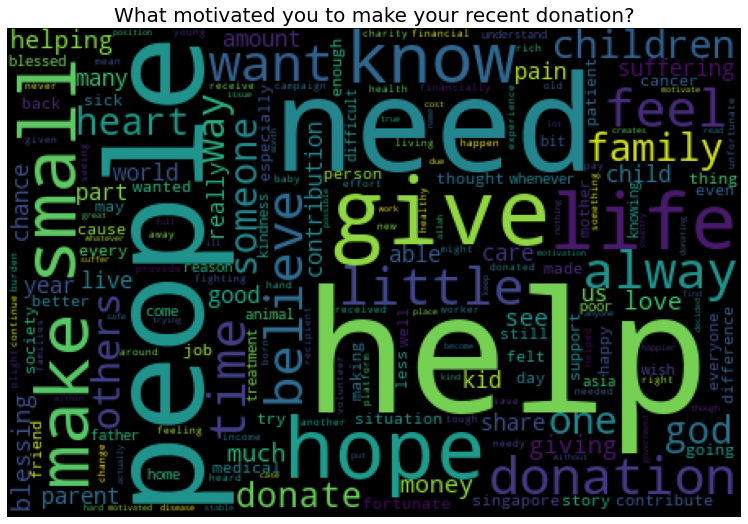

In [140]:
text = WordCloud(width=450,height= 300).generate(' '.join(q1_ngram['unigram/bigram']))
plt.figure(figsize=(19,9))
plt.axis('off')
plt.title("What motivated you to make your recent donation?",fontsize=20)
plt.imshow(text)
plt.show()

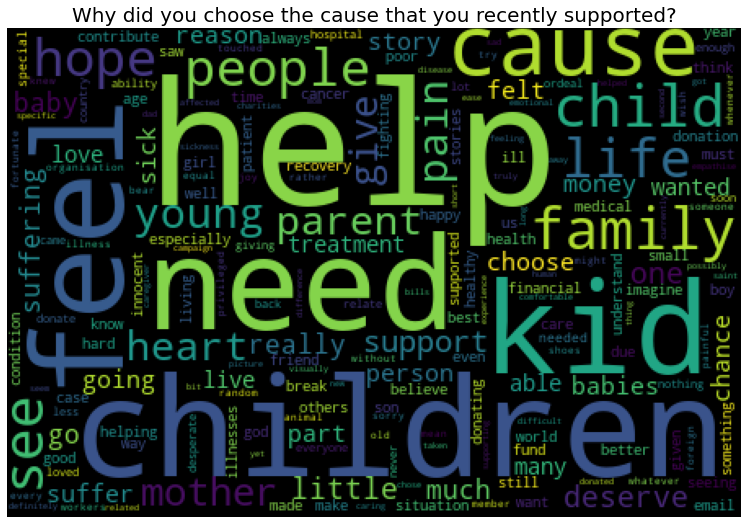

In [141]:
text_2 = WordCloud(width=450,height= 300).generate(' '.join(q2_ngram['unigram/bigram']))
plt.figure(figsize=(19,9))
plt.axis('off')
plt.title("Why did you choose the cause that you recently supported?",fontsize=20)
plt.imshow(text_2)
plt.show()

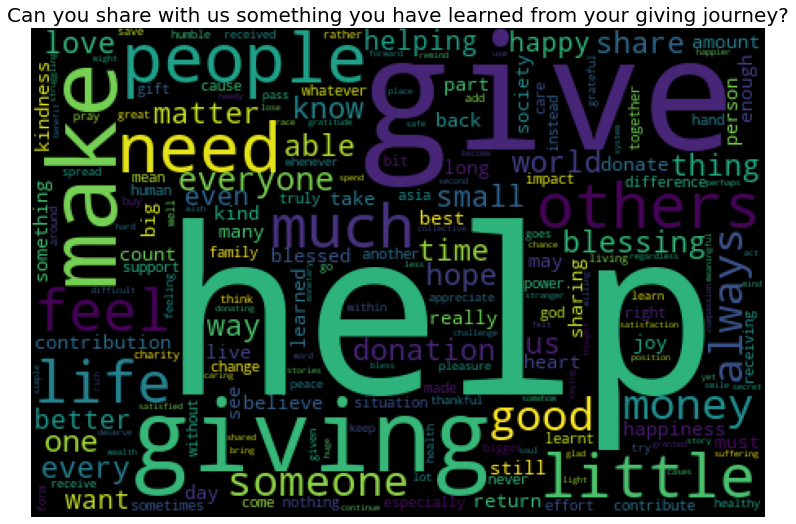

In [142]:
text_3 = WordCloud(width=450,height= 300).generate(' '.join(q3_ngram['unigram/bigram']))
plt.figure(figsize=(19,9))
plt.axis('off')
plt.title("Can you share with us something you have learned from your giving journey?",fontsize=20)
plt.imshow(text_3)
plt.show()

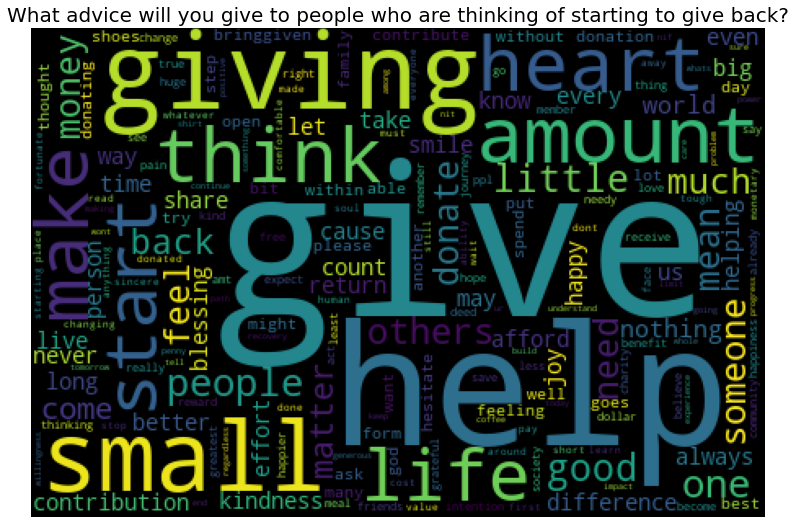

In [143]:
text_4 = WordCloud(width=450,height= 300).generate(' '.join(q4_ngram['unigram/bigram']))
plt.figure(figsize=(19,9))
plt.axis('off')
plt.title("What advice will you give to people who are thinking of starting to give back?",fontsize=20)
plt.imshow(text_4)
plt.show()

In [123]:
#to convert cleaned data to series, not a dataframe
q1_tvec = df['cleaned_tokens_q1'].apply(lambda row: ' '.join(row))
q2_tvec = df['cleaned_tokens_q2'].apply(lambda row: ' '.join(row))
q3_tvec = df['cleaned_tokens_q3'].apply(lambda row: ' '.join(row))
q4_tvec = df['cleaned_tokens_q4'].apply(lambda row: ' '.join(row))

In [122]:
#tfidfvectorizer
vec = TfidfVectorizer(stop_words = 'english')

In [124]:
vec.fit(q1_tvec)

TfidfVectorizer(stop_words='english')

In [125]:
features = vec.transform(q1_tvec)

In [126]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA

In [128]:
cls = MiniBatchKMeans(n_clusters=5, random_state = 0)
cls.fit(features)

MiniBatchKMeans(n_clusters=5, random_state=0)

In [129]:
#predict cluster labels for new dataset
cls.predict(features)

array([3, 1, 3, 1, 1, 2, 2, 1, 2, 1, 1, 4, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2,
       1, 1, 2, 1, 1, 1, 0, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 2, 2, 4, 0,
       2, 2, 1, 3, 2, 2, 2, 2, 3, 3, 1, 3, 2, 4, 1, 2, 1, 4, 4, 1, 0, 2,
       1, 2, 2, 1, 1, 2, 2, 4, 2, 2, 3, 1, 2, 1, 0, 1, 4, 1, 3, 1, 2, 1,
       2, 1, 0, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 2, 3, 0, 1, 1, 1,
       1, 2, 2, 1, 1, 0, 3, 1, 2, 2, 2, 1, 0, 4, 2, 1, 1, 1, 3, 2, 1, 2,
       3, 1, 1, 2, 0, 2, 1, 1, 1, 1, 2, 1, 1, 2, 0, 3, 1, 1, 1, 2, 1, 1,
       2, 0, 1, 2, 1, 2, 2, 3, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 2, 1,
       1, 1, 1, 1, 0, 1, 0, 2, 2, 1, 1, 4, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1,
       4, 3, 2, 1, 2, 1, 3, 1, 1, 1, 2, 2, 1, 1, 1, 3, 1, 1, 1, 1, 1, 4,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 1, 2, 3, 3, 0, 1, 1, 1, 3, 1, 2, 1, 2, 1, 1, 1, 3, 3, 1, 0,
       2, 4, 2, 1, 1, 1, 2, 1, 2, 4, 3, 2, 1, 4, 3, 2, 1, 4, 3, 2, 1, 3,
       1, 0, 1, 1, 1, 2, 1, 3, 1, 1, 1, 1, 1, 1, 1,

In [130]:
#to get cluster labels for the dataset used while training the model
#(used for models that does not support prediction on new dataset)
cls.labels_

array([3, 1, 3, 1, 1, 2, 2, 1, 2, 1, 1, 4, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2,
       1, 1, 2, 1, 1, 1, 0, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 2, 2, 4, 0,
       2, 2, 1, 3, 2, 2, 2, 2, 3, 3, 1, 3, 2, 4, 1, 2, 1, 4, 4, 1, 0, 2,
       1, 2, 2, 1, 1, 2, 2, 4, 2, 2, 3, 1, 2, 1, 0, 1, 4, 1, 3, 1, 2, 1,
       2, 1, 0, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 2, 3, 0, 1, 1, 1,
       1, 2, 2, 1, 1, 0, 3, 1, 2, 2, 2, 1, 0, 4, 2, 1, 1, 1, 3, 2, 1, 2,
       3, 1, 1, 2, 0, 2, 1, 1, 1, 1, 2, 1, 1, 2, 0, 3, 1, 1, 1, 2, 1, 1,
       2, 0, 1, 2, 1, 2, 2, 3, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 2, 1,
       1, 1, 1, 1, 0, 1, 0, 2, 2, 1, 1, 4, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1,
       4, 3, 2, 1, 2, 1, 3, 1, 1, 1, 2, 2, 1, 1, 1, 3, 1, 1, 1, 1, 1, 4,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 1, 2, 3, 3, 0, 1, 1, 1, 3, 1, 2, 1, 2, 1, 1, 1, 3, 3, 1, 0,
       2, 4, 2, 1, 1, 1, 2, 1, 2, 4, 3, 2, 1, 4, 3, 2, 1, 4, 3, 2, 1, 3,
       1, 0, 1, 1, 1, 2, 1, 3, 1, 1, 1, 1, 1, 1, 1,

In [133]:
#visualization - to reduce dimension, we use PCA to transform our high dimensional features into 2D

#reduce the features to 2D
pca = PCA(n_components = 2, random_state = 0)
reduced_features = pca.fit_transform(features.toarray())

#reduce the cluster centers to 2D
reduced_cluster_centers = pca.transform(cls.cluster_centers_)

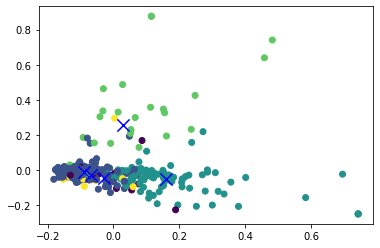

In [134]:
plt.scatter(reduced_features[:,0], reduced_features[:,1], c=cls.predict(features))
plt.scatter(reduced_cluster_centers[:,0], reduced_cluster_centers[:,1], marker = 'x', s = 150, c='b')

In [136]:
#evaluation with unlabelled dataset using silhouette coefficient
from sklearn.metrics import silhouette_score
silhouette_score(features, labels = cls.predict(features))

0.009526572067792895

The Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. The Silhouette Coefficient for a sample is (b - a) / max(a,b). To clarify, b is the distance between a sample and the nearest cluster that the sample is not a part of.

The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.

This value means that our clusters are overlapping. We can also see this in the plot above. Perhaps tuning different parameters for feature extractor and the clustering model will increase this score. 

In [150]:
#checking for optimal number of clusters

from sklearn.cluster import KMeans

In [152]:
sum_of_squared_distances = []
K = range(1,150)
for k in K:
    km = KMeans(n_clusters = k)
    km = km.fit(features)
    sum_of_squared_distances.append(km.inertia_)

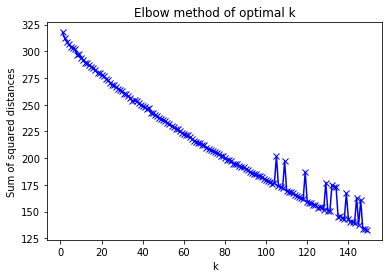

In [153]:
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow method of optimal k')
plt.show()

### Save data to csv files

In [50]:
#save file as csv
#result_cleaned.to_csv('../dataset/result_cleaned.csv')